In [22]:
import glob
import uproot
import numpy as np
from sbtveto.model.nn_model import NN
import torch

In [23]:
!ls ../NN_data

h5_files  root_files  SBT_new_geo_XYZ.npy  SBT_XYZ.npy	signal


In [24]:
XYZ =np.load("../NN_data/SBT_new_geo_XYZ.npy")

In [25]:
!ls ../NN_data/signal

datafile_EMBG_0_0.h5  datafile_EMBG_0_0.root


In [26]:
neu_files = glob.glob("../new_NN_data/root_files/*neuDIS*.root")
mu_files = glob.glob("../new_NN_data/root_files/*muDIS*.root")
#embg_files = glob.glob("../SBT/ml_dataset/*EMBG*.root")
embg_files = glob.glob("../new_NN_data/root_files/*EMBG*.root")

In [27]:
#embg_files

In [28]:
#len(mu_files)

In [29]:
#file = uproot.open(neu_files[0])

In [30]:
#x = file['tree;1']['inputmatrix'].array()

In [31]:
#x = np.array(x)

In [43]:
# prepare data from a root format

to_concat = []
ys_concat = []
N=0
for i in range(0,10):
    file = uproot.open(neu_files[i])
    x = file['tree;1']['inputmatrix'].array()
    x = np.array(x)
    # store SBT E, vertex x,y,z, t and signal info
    x = np.hstack([x[:,:854],x[:,1708:1712], x[:, 1714:1717]])
    #x = x[:,:1712]
    N += x.shape[0]
    to_concat.append(x)
ys_concat.append(np.ones((N)))
print(N)
N=0
for i in range(0,120):
    file = uproot.open(mu_files[i])

    x = file['tree;1']['inputmatrix'].array()
    x = np.array(x)
    if x.shape[0] < 1:
        continue
    x = np.hstack([x[:,:854],x[:,1708:1712], x[:, 1714:1717]])
    #x = x[:,:1712]
    N += x.shape[0]
    to_concat.append(x)
ys_concat.append(2*np.ones((N)))
print(N)
N=0
for i in range(0,4):
    file = uproot.open(embg_files[i])
    x = file['tree;1']['inputmatrix'].array()
    x = np.array(x)
    x = np.hstack([x[:,:854],x[:,1708:1712], x[:, 1714:1717]])
    #x = x[:,:1712]
    N += x.shape[0]
    to_concat.append(x)
print(N)
ys_concat.append(np.zeros((N)))

13102
15197
16562


In [44]:
#X

In [45]:
#X=np.concatenate(to_concat)[:,:-1]
# get rid of last too columns no. ubt cells and  fill weight
X=np.concatenate(to_concat) #[:,:-2]

In [46]:
X.shape

(44861, 861)

In [47]:
X.shape

(44861, 861)

In [48]:
#X[0,:2000].shape

In [49]:
# cut out cells without SBT hits
Xcut = X[np.sum(X[:,:854],1)>0][:,:-3]

In [50]:
Xsig = X[np.sum(X[:,:854],1)>0][:,-3:]

In [51]:
Xcut.shape

(43558, 858)

In [52]:
y=np.concatenate(ys_concat)
y = y.astype(int)
ycut = y[np.sum(X[:,:854],1)>0]

In [53]:
from sklearn.model_selection import train_test_split
import torch
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
import joblib

In [54]:
scaler = RobustScaler()
#scaler = StandardScaler()
#scaler = MinMaxScaler()
scaler.fit(Xcut)

RobustScaler()

In [55]:
Xcut = scaler.transform(Xcut)

In [56]:
joblib.dump(scaler, 'robust_scaler.pkl')

['robust_scaler.pkl']

In [57]:
scaler.get_params()

{'copy': True,
 'quantile_range': (25.0, 75.0),
 'unit_variance': False,
 'with_centering': True,
 'with_scaling': True}

In [58]:
#scaler.scale_

In [27]:
import json

scaler_params = {
     'center_': scaler.center_.tolist(),
     'scale_': scaler.scale_.tolist()
 }

with open('data/robust_scaler_new_geo.json', 'w') as f:
    json.dump(scaler_params, f)

In [59]:
X = torch.tensor(Xcut, dtype=torch.float)
ycut= torch.tensor(ycut, dtype=torch.int64)
#ycut= torch.tensor(ycut, dtype=torch.float)
Xsig= torch.tensor(Xsig, dtype=torch.float)

In [60]:
X.shape

torch.Size([43558, 858])

In [61]:
X_train, X_test, y_train, y_test, X_sig_train, X_sig_test = train_test_split(X,ycut, Xsig ,test_size= 0.2)

In [62]:
X_sig_train.shape

torch.Size([34846, 3])

In [80]:
import torch
from torch_geometric.loader import DataLoader

traindata = torch.utils.data.TensorDataset(X_train,y_train, X_sig_train)
train_loader = DataLoader(traindata, batch_size=32, shuffle=True)

In [81]:

testdata = torch.utils.data.TensorDataset(X_test, y_test, X_sig_test)
val_loader = DataLoader(testdata, batch_size=32, shuffle=True )

In [82]:
X_test.shape

torch.Size([8712, 858])

In [83]:
#multiple targets 3 targets
#network = NN(2003,3,[32,32,32,16,8], dropout=0)
network = NN(858,3,[32,32,32,16,8], dropout=0)

#network = NN(1712,1,[32,32,32,16,8], dropout=0)

In [84]:
for b in train_loader:
    #print(b)
    network(b[0])
    break

In [85]:
network

NN(
  (_layers): ModuleList(
    (0): Linear(in_features=858, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=8, bias=True)
  )
  (_batch_norms): ModuleList(
    (0-1): 2 x BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (_dropout): Dropout(p=0, inplace=False)
  (_output_layer): Linear(in_features=8, out_features=3, bias=True)
)

In [86]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [87]:
# number of pars in the network
count_parameters(network)

29411

In [88]:
from torch import nn


In [89]:
device='cuda'

model = network
model.cuda()

# Loss and optimizer
BCE_criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

from datetime import datetime

In [90]:
CE_criterion = nn.CrossEntropyLoss()

In [91]:
model = model.cuda()

epoch_log = []
loss_log = []
val_loss_log = []
accuracy_log = []
val_accuracy_log = []

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
sig = nn.Sigmoid()

In [93]:
epochs = 10
    

for epoch in range(epochs):  
    print(f'Epoch: {epoch+1}')

    running_loss = 0.0
    running_correct = 0.0 
    running_total = 0.0
    actual_loss = 0.0
    # loop over training batches
    for i, data in enumerate(train_loader, 0):
        inputs, labels, sig = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        # clear gradients
        optimizer.zero_grad()

        # forward propagation
        outputs = model(inputs)

        # compute loss
        loss =  criterion(outputs, labels)

        # backward propagation
        loss.backward()
        optimizer.step()

        # add batch loss to running loss
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, dim = 1)

        running_total += labels.size(0)

        running_correct += (predicted == labels).sum().item()

        if i % 400 == 399:    
            valcorrect = 0 
            valtotal = 0 
            running_val_loss = 0

            with torch.no_grad():
                for data in val_loader:

                    x, labels, sig = data

                    x = x.to(device)
                    labels = labels.to(device)

                    outputs = model(x)

                    val_loss =  criterion(outputs, labels)

                    _, predicted = torch.max(outputs.data, dim = 1)

                    valtotal += labels.size(0)

                    valcorrect += (predicted == labels).sum().item()
                    
                    running_val_loss += val_loss.item() 

                val_accuracy = 100 * valcorrect / valtotal
                accuracy = 100 * running_correct / running_total
                epoch_num = epoch + 1
                
                print(f'Epoch: {epoch_num}, Mini-Batches Completed: {(i+1)} Train Accuracy = {accuracy:.3f}%')
                print(f'Epoch: {epoch_num}, Mini-Batches Completed: {(i+1)} Val Accuracy = {val_accuracy:.3f}%')
                

    actual_loss = running_loss / running_total
    actual_val_loss = running_val_loss / valtotal
    epoch_log.append(epoch_num)
    loss_log.append(actual_loss)
    val_loss_log.append(actual_val_loss)
    accuracy_log.append(accuracy)
    val_accuracy_log.append(val_accuracy)
    print('\n')
    print(f"Epoch {epoch_num} summary stats:")
    print(f'Train Loss: {actual_loss:.4f}, Train Accuracy = {accuracy:.3f}%')
    print(f'Val Loss: {actual_val_loss:.4f}, Val Accuracy = {val_accuracy:.3f}%')
    print('\n')
    print('\n')

Epoch: 1
Epoch: 1, Mini-Batches Completed: 400 Train Accuracy = 75.203%
Epoch: 1, Mini-Batches Completed: 400 Val Accuracy = 82.048%
Epoch: 1, Mini-Batches Completed: 800 Train Accuracy = 79.273%
Epoch: 1, Mini-Batches Completed: 800 Val Accuracy = 83.838%


Epoch 1 summary stats:
Train Loss: 0.0155, Train Accuracy = 79.273%
Val Loss: 0.0128, Val Accuracy = 83.838%




Epoch: 2
Epoch: 2, Mini-Batches Completed: 400 Train Accuracy = 86.156%
Epoch: 2, Mini-Batches Completed: 400 Val Accuracy = 85.193%
Epoch: 2, Mini-Batches Completed: 800 Train Accuracy = 86.676%
Epoch: 2, Mini-Batches Completed: 800 Val Accuracy = 86.559%


Epoch 2 summary stats:
Train Loss: 0.0108, Train Accuracy = 86.676%
Val Loss: 0.0111, Val Accuracy = 86.559%




Epoch: 3
Epoch: 3, Mini-Batches Completed: 400 Train Accuracy = 88.203%
Epoch: 3, Mini-Batches Completed: 400 Val Accuracy = 87.902%
Epoch: 3, Mini-Batches Completed: 800 Train Accuracy = 88.113%
Epoch: 3, Mini-Batches Completed: 800 Val Accuracy = 87.615%

In [45]:
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [46]:
#torch.save(model.state_dict(), 'SBTveto_vacuum_multiclass_NN_SBT_E_signal_xyz.pth')

In [47]:
#!ls data

In [48]:
#model.load_state_dict(torch.load("data/SBTveto_vacuum_multiclass_NN_SBT_E_signal_xyz.pth", weights_only=True))
#model.eval()

In [94]:
ypreds=[]
ys =[]
sig_vars = []
preds = []

In [96]:
for data in val_loader:

    # apply model to validation batch
    x, labels, sig = data

    x = x.to(device)
    labels = labels.to(device)

    outputs = model(x)

    val_loss =  criterion(outputs, labels)

    _, predicted = torch.max(outputs.data, dim = 1)
    ys.append(labels.cpu().detach().numpy())
    ypreds.append(predicted.cpu().detach().numpy())

In [97]:
ypred = np.concatenate(ypreds)
true = np.concatenate(ys)

In [98]:
np.sum(ypred==true)/len(ypred)

np.float64(0.907139577594123)

In [99]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

In [100]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true, ypred)

In [102]:
cmnew =cm/np.expand_dims(np.sum(cm,1),1)

In [103]:
def plot_errorband(x, y, y_err, label, color):
    plt.plot(x, y, color=color, ls='solid', label=label)
    plt.fill_between(x, y_err[0],y_err[1], color=color, alpha=0.3, lw=0)
   
    
def init_thesis_plot_style():
    my_rc_params = {
        "xtick.direction": "in",
        "xtick.major.size": 8.0,
        "xtick.minor.size": 4.0,
        "xtick.minor.visible": True,
        "xtick.major.width": 1.2,
        "xtick.minor.width": 0.9,
        "ytick.direction": "in",
        "ytick.major.size": 8.0,
        "ytick.minor.size": 4.0,
        "ytick.minor.visible": True,
        "ytick.major.width": 1.2,
        "ytick.minor.width": 0.9,
        "errorbar.capsize": 2,
        "axes.linewidth": 1.2,
        # "font.familiy": "serif",
        "font.size": 14,
        "axes.grid": False,
        "ytick.right": True,
        "xtick.top": True
    }
    return(my_rc_params)
class Tango(object):
    scarlet_red_light = '#ef2929'
    scarlet_red = '#cc0000'
    scarlet_red_dark = '#a40000'

    aluminium_light = '#eeeeec'
    aluminium = '#d3d7cf'
    aluminium_dark = '#babdb6'

    butter_light = '#fce94f'
    butter = '#edd400'
    butter_dark = '#c4a000'

    chameleon_light = '#8ae234'
    chameleon = '#73d216'
    chameleon_dark = '#4e9a06'

    orange_light = '#fcaf3e'
    orange = '#f57900'
    orange_dark = '#ce5c00'

    chocolate_light = '#e9b96e'
    chocolate = '#c17d11'
    chocolate_dark = '#8f5902'

    sky_blue_light = '#729fcf'
    sky_blue = '#3465a4'
    sky_blue_dark = '#204a87'

    plum_light = '#ad7fa8'
    plum = '#75507b'
    plum_dark = '#5c3566'

    slate_light = '#888a85'
    slate = '#555753'
    slate_dark = '#2e3436'

init_thesis_plot_style()
plt.rcParams.update(init_thesis_plot_style())

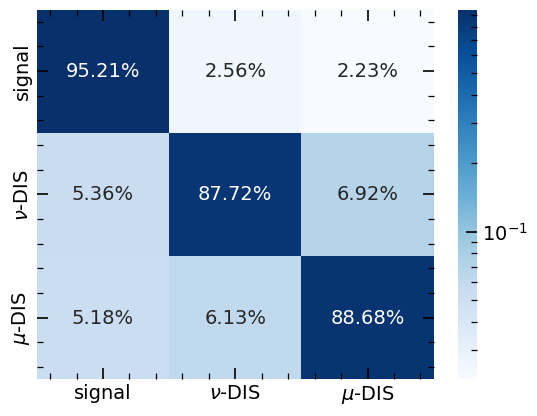

In [104]:
import seaborn as sns
from matplotlib.colors import LogNorm
sns.heatmap(cmnew, 
            fmt='.2%', norm= LogNorm(),
            annot=True,  xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.savefig('NN_SHIP_Oct_Confusion.png')

In [56]:
all_sig_var.shape

(3674, 3)

In [101]:
labels=['signal',r'$\nu$-DIS', r'$\mu$-DIS']
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true, preds)

ValueError: Found input variables with inconsistent numbers of samples: [8712, 0]

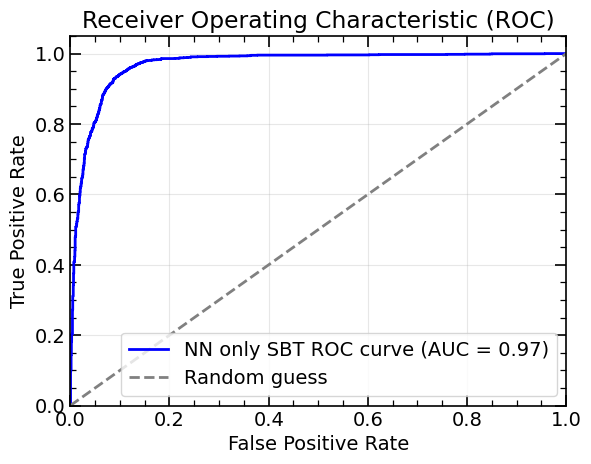

In [78]:
fpr, tpr, thresholds = roc_curve(true, all_preds)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'NN only SBT ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
#plt.show()
plt.savefig("NN_only_sbt_ROC.png")

In [79]:
corr = np.corrcoef(x=all_preds.flatten(),y=all_sig_var[:,0].flatten())

In [80]:
print(corr)

[[1.        0.1109747]
 [0.1109747 1.       ]]


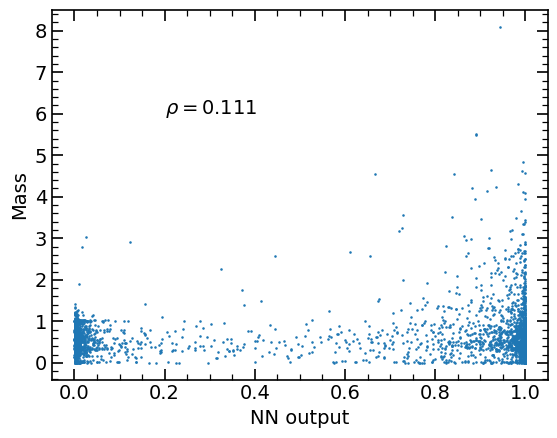

In [81]:
plt.scatter(all_preds,all_sig_var[:,0],s=0.7)
plt.text(0.2,6, r'$\rho=${0:.3f}'.format(corr[0][1]))
plt.ylabel("Mass")

plt.xlabel("NN output")
plt.savefig("Mass_vs_SBT_NN.png")

In [82]:
all_preds.shape

(3674, 1)

In [83]:
corr = np.corrcoef(x=all_preds.flatten(),y=all_sig_var[:,1].flatten())

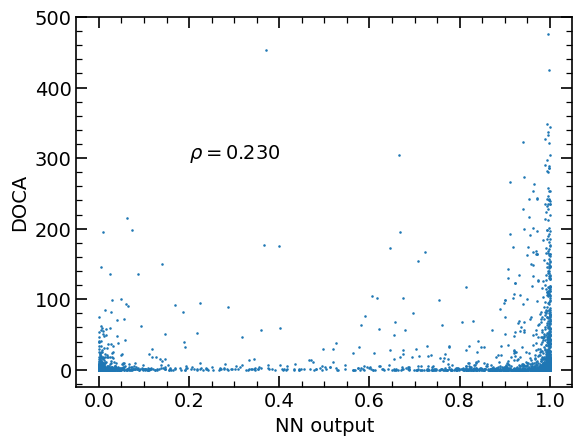

In [84]:
plt.scatter(all_preds,all_sig_var[:,1],s=0.7)
plt.text(0.2,300, r'$\rho=${0:.3f}'.format(corr[0][1]))
plt.ylabel("DOCA")

plt.xlabel("NN output")
plt.savefig("DOCA_vs_SBT_NN.png")

In [85]:
corr = np.corrcoef(x=all_preds.flatten(),y=all_sig_var[:,2].flatten())

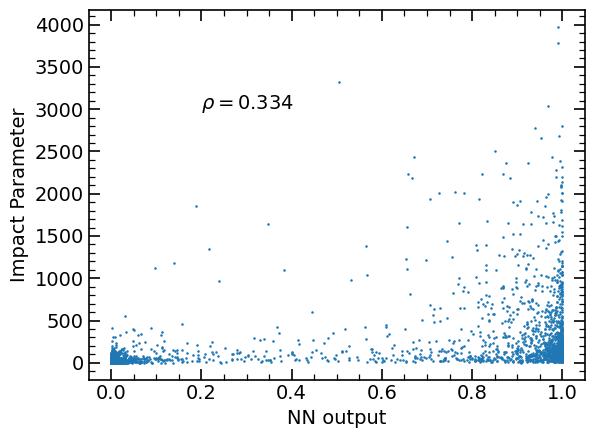

In [88]:
plt.scatter(all_preds,all_sig_var[:,2],s=0.7)
plt.text(0.2,3000, r'$\rho=${0:.3f}'.format(corr[0][1]))
plt.ylabel("Impact Parameter")

plt.xlabel("NN output")
plt.savefig("IP_vs_SBT_NN.png")

In [66]:
np.corrcoef(x=all_preds.flatten(),y=all_sig_var[:,2].flatten())

array([[1.       , 0.3343106],
       [0.3343106, 1.       ]])

In [67]:
np.sum(ypred==true)/len(ypred)

np.float64(0.9205225911812738)

In [68]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

In [69]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true, ypred)

In [70]:
cm

array([[1641,  197],
       [  95, 1741]])

In [71]:
cm

array([[1641,  197],
       [  95, 1741]])

In [72]:
preds=ypred

In [73]:
np.sum(preds == true)/true.shape[0]

np.float64(0.9205225911812738)

In [74]:
labels=['signal',r'$\nu$-DIS']#, r'$\mu$-DIS']
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true, preds)

In [75]:
cmnew =cm/np.expand_dims(np.sum(cm,1),1)

In [76]:
def plot_errorband(x, y, y_err, label, color):
    plt.plot(x, y, color=color, ls='solid', label=label)
    plt.fill_between(x, y_err[0],y_err[1], color=color, alpha=0.3, lw=0)
   
    
def init_thesis_plot_style():
    my_rc_params = {
        "xtick.direction": "in",
        "xtick.major.size": 8.0,
        "xtick.minor.size": 4.0,
        "xtick.minor.visible": True,
        "xtick.major.width": 1.2,
        "xtick.minor.width": 0.9,
        "ytick.direction": "in",
        "ytick.major.size": 8.0,
        "ytick.minor.size": 4.0,
        "ytick.minor.visible": True,
        "ytick.major.width": 1.2,
        "ytick.minor.width": 0.9,
        "errorbar.capsize": 2,
        "axes.linewidth": 1.2,
        # "font.familiy": "serif",
        "font.size": 14,
        "axes.grid": False,
        "ytick.right": True,
        "xtick.top": True
    }
    return(my_rc_params)
class Tango(object):
    scarlet_red_light = '#ef2929'
    scarlet_red = '#cc0000'
    scarlet_red_dark = '#a40000'

    aluminium_light = '#eeeeec'
    aluminium = '#d3d7cf'
    aluminium_dark = '#babdb6'

    butter_light = '#fce94f'
    butter = '#edd400'
    butter_dark = '#c4a000'

    chameleon_light = '#8ae234'
    chameleon = '#73d216'
    chameleon_dark = '#4e9a06'

    orange_light = '#fcaf3e'
    orange = '#f57900'
    orange_dark = '#ce5c00'

    chocolate_light = '#e9b96e'
    chocolate = '#c17d11'
    chocolate_dark = '#8f5902'

    sky_blue_light = '#729fcf'
    sky_blue = '#3465a4'
    sky_blue_dark = '#204a87'

    plum_light = '#ad7fa8'
    plum = '#75507b'
    plum_dark = '#5c3566'

    slate_light = '#888a85'
    slate = '#555753'
    slate_dark = '#2e3436'

init_thesis_plot_style()
plt.rcParams.update(init_thesis_plot_style())

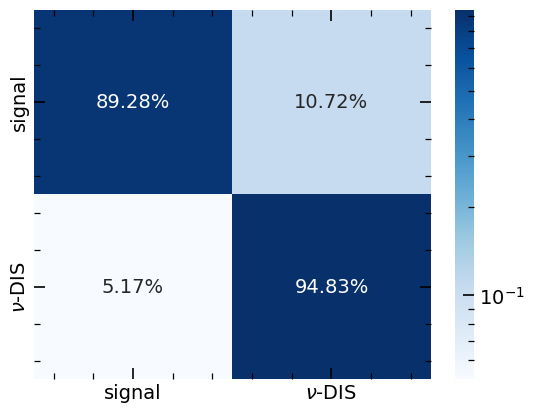

In [87]:
import seaborn as sns
from matplotlib.colors import LogNorm
sns.heatmap(cmnew, 
            fmt='.2%', norm= LogNorm(),
            annot=True,  xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.savefig('NN_SHIP_Dec_Confusion_binary.png')

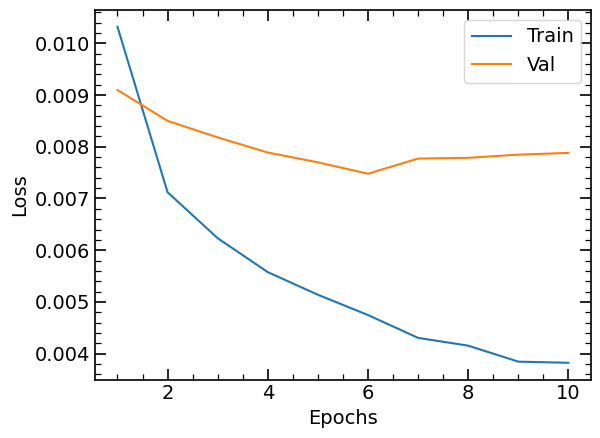

In [349]:
import matplotlib.pyplot as plt
epochs = np.arange(0 ,len(loss_log)+1)

plt.plot(epochs[1:],np.array(loss_log), label="Train")
plt.plot(epochs[1:],np.array(val_loss_log), label="Val")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [131]:
epochs

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])